In [81]:
import random
import os
import glob
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt
import wordcloud

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [2]:
INPUT_DIR = "/home/sagemaker-user/artifacts/raw"
print(os.listdir(INPUT_DIR))

print("INPUT_DIR:", INPUT_DIR)
print("Exists:", os.path.exists(INPUT_DIR))
print("Files:", os.listdir(INPUT_DIR))


['anime_with_synopsis.csv', 'anime.csv', 'animelist.csv']
INPUT_DIR: /home/sagemaker-user/artifacts/raw
Exists: True
Files: ['anime_with_synopsis.csv', 'anime.csv', 'animelist.csv']


In [3]:
rating_df = pd.read_csv(INPUT_DIR+"/animelist.csv" , low_memory=True,usecols=["user_id","anime_id","rating"])

In [4]:
rating_df.head()

,user_id,anime_id,rating
0,0,67,9.0
1,0,6702,7.0
2,0,242,10.0
3,0,4898,0.0
4,0,21,10.0


In [5]:
len(rating_df)

7385508

In [6]:
n_ratings = rating_df["user_id"].value_counts()
rating_df = rating_df[rating_df["user_id"].isin(n_ratings[n_ratings>=400].index)].copy()

In [7]:
len(rating_df)

4809166

In [8]:
min_rating = min(rating_df["rating"])

In [9]:
max_rating = max(rating_df["rating"])

In [10]:
max_rating

10.0

In [11]:
avg_rating = np.mean(rating_df["rating"])

In [12]:
avg_rating

4.084613423616486

In [13]:
rating_df["rating"] = rating_df["rating"].apply(lambda x: (x-min_rating)/(max_rating-min_rating)).values.astype(np.float64)

In [14]:
rating_df.duplicated().sum()

0

In [15]:
rating_df.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [16]:
user_ids = rating_df["user_id"].unique().tolist()
user2user_encoded = {x : i for i , x in enumerate(user_ids)}
user2user_decoded = {i : x for i , x in enumerate(user_ids)}
rating_df["user"] = rating_df["user_id"].map(user2user_encoded)

In [17]:
n_users = len(user2user_encoded)

In [18]:
n_users

6168

In [19]:
anime_ids = rating_df["anime_id"].unique().tolist()
anime2anime_encoded = {x : i for i , x in enumerate(anime_ids)}
anime2anime_decoded = {i : x for i , x in enumerate(anime_ids)}
rating_df["anime"] = rating_df["anime_id"].map(anime2anime_encoded)

In [20]:
n_anime = len(anime2anime_encoded)

In [21]:
n_anime

17554

In [22]:
rating_df = rating_df.sample(frac=1,random_state=43).reset_index(drop=True)

In [23]:
rating_df.head(2)

,user_id,anime_id,rating,user,anime
0,16869,2746,0.0,4294,2446
1,19497,14345,0.7,4982,1149


In [24]:
X = rating_df[["user","anime"]].values
y = rating_df["rating"]

In [25]:
test_size = 1000
train_indices = rating_df.shape[0] - test_size

In [26]:
X_train , X_test , y_train , y_test = (
    X[:train_indices],
    X[train_indices :],
    y[:train_indices],
    y[train_indices:],
)

In [27]:
len(X_train)

4808166

In [28]:
len(X_test)

1000

In [29]:
type(X_train)

numpy.ndarray

In [30]:
USE_TEMPORAL_SPLIT = False

if USE_TEMPORAL_SPLIT and 'timestamp' in rating_df.columns:
    sorted_df = rating_df.sort_values('timestamp')
    split_idx = int(len(sorted_df) * 0.85)
    train_indices = sorted_df.index[:split_idx]
    test_indices = sorted_df.index[split_idx:]
    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y.iloc[train_indices], y.iloc[test_indices]
    print("Using TEMPORAL split (train on past, test on future)")
else:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, shuffle=True)
    print("Using RANDOM split (temporal data not available)")

X_train_users = torch.LongTensor(X_train[:, 0])
X_train_animes = torch.LongTensor(X_train[:, 1])
y_train_tensor = torch.FloatTensor(y_train.values)
X_test_users = torch.LongTensor(X_test[:, 0])
X_test_animes = torch.LongTensor(X_test[:, 1])
y_test_tensor = torch.FloatTensor(y_test.values)

Using RANDOM split (temporal data not available)


In [31]:
type(X_test_users)

torch.Tensor

In [32]:
type(X_test_users)

torch.Tensor

In [33]:
class RecommenderNet(nn.Module):
    def __init__(self, n_users, n_anime, embedding_size=64):
        super(RecommenderNet, self).__init__()
        self.user_embedding = nn.Embedding(n_users, embedding_size)
        self.anime_embedding = nn.Embedding(n_anime, embedding_size)
    def forward(self, user_input, anime_input):
        user_vec = self.user_embedding(user_input)
        anime_vec = self.anime_embedding(anime_input)
        dot_product = torch.sum(user_vec * anime_vec, dim=1)
        user_norm = torch.norm(user_vec, dim=1, keepdim=True)
        anime_norm = torch.norm(anime_vec, dim=1, keepdim=True)
        normalized_score = dot_product / (user_norm.squeeze() * anime_norm.squeeze() + 1e-8)
        return normalized_score

In [34]:
CONFIG = {
    'TRAINING_MODE': 'MSE',
    'embedding_size': 64,
    'start_lr': 0.00001,
    'min_lr': 0.0001,
    'max_lr': 0.00005,
    'batch_size': 10000,
    'ramup_epochs': 5,
    'sustain_epochs': 0,
    'exp_decay': 0.8,
    'epochs': 20,
    'patience': 3,
    'weight_decay': 1e-5,
    'n_negatives': 5,
    'bpr_batch_size': 256,
    'save_dir': os.path.abspath(os.path.join(INPUT_DIR, '..', '..', 'models'))
}

os.makedirs(CONFIG['save_dir'], exist_ok=True)
print(f"Models will be saved to: {CONFIG['save_dir']}")

def lrfn(epoch):
    if epoch < CONFIG['ramup_epochs']:
        return (CONFIG['max_lr'] - CONFIG['start_lr']) / CONFIG['ramup_epochs'] * epoch + CONFIG['start_lr']
    elif epoch < CONFIG['ramup_epochs'] + CONFIG['sustain_epochs']:
        return CONFIG['max_lr']
    else:
        return (CONFIG['max_lr'] - CONFIG['min_lr']) * CONFIG['exp_decay'] ** (epoch - CONFIG['ramup_epochs'] - CONFIG['sustain_epochs']) + CONFIG['min_lr']

Models will be saved to: /home/sagemaker-user/models


In [35]:
model = RecommenderNet(n_users, n_anime, embedding_size=CONFIG['embedding_size']).to(device)
optimizer = optim.Adam(model.parameters(), lr=CONFIG['start_lr'], weight_decay=CONFIG['weight_decay'])
criterion = nn.MSELoss()

In [36]:
anime_popularity = rating_df.groupby('anime_id').size().to_dict()
total_interactions = sum(anime_popularity.values())
anime_pop_probs = {k: v / total_interactions for k, v in anime_popularity.items()}

def sample_negatives_weighted(user_id, user_anime_df, n_anime, n_negatives=5):
    watched = set(user_anime_df[user_anime_df['user'] == user_id]['anime'].values)
    candidates = [a for a in range(n_anime) if a not in watched]
    if len(candidates) < n_negatives:
        return candidates + [candidates[0]] * (n_negatives - len(candidates))
    anime_ids_orig = [anime2anime_decoded.get(a, None) for a in candidates]
    probs = np.array([anime_pop_probs.get(aid, 1e-10) for aid in anime_ids_orig])
    probs = probs / probs.sum()
    return np.random.choice(candidates, size=n_negatives, replace=False, p=probs).tolist()

def sample_negatives(user_id, user_anime_df, n_anime, n_negatives=5):
    watched = set(user_anime_df[user_anime_df['user'] == user_id]['anime'].values)
    candidates = [a for a in range(n_anime) if a not in watched]
    if len(candidates) < n_negatives:
        return candidates + [candidates[0]] * (n_negatives - len(candidates))
    return np.random.choice(candidates, size=n_negatives, replace=False).tolist()

In [37]:
def bpr_loss(pos_scores, neg_scores):
    neg_avg = torch.mean(neg_scores.view(-1, CONFIG['n_negatives']), dim=1)
    return -torch.mean(torch.log(torch.sigmoid(pos_scores - neg_avg) + 1e-10))

def contrastive_loss(pos_scores, neg_scores, temperature=0.1):
    pos_exp = torch.exp(pos_scores / temperature)
    neg_exp = torch.sum(torch.exp(neg_scores / temperature))
    return -torch.mean(torch.log(pos_exp / (pos_exp + neg_exp) + 1e-10))

In [38]:
class LRScheduler:
    def __init__(self, optimizer, lrfn):
        self.optimizer = optimizer
        self.lrfn = lrfn

    def step(self, epoch):
        lr = self.lrfn(epoch)
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr

scheduler = LRScheduler(optimizer, lrfn)

In [39]:
train_dataset = TensorDataset(X_train_users, X_train_animes, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], shuffle=True)

test_dataset = TensorDataset(X_test_users, X_test_animes, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=CONFIG['batch_size'])

In [40]:
def train_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss, total_mae, total_mse = 0, 0, 0
    num_batches = 0
    pbar = tqdm(train_loader, desc="Training", leave=False)
    for users, animes, ratings in pbar:
        users, animes, ratings = users.to(device), animes.to(device), ratings.to(device)
        optimizer.zero_grad()
        outputs = model(users, animes)
        loss = criterion(outputs, ratings)
        loss.backward()
        optimizer.step()
        mae = torch.mean(torch.abs(outputs - ratings))
        mse = torch.mean((outputs - ratings) ** 2)
        total_loss += loss.item()
        total_mae += mae.item()
        total_mse += mse.item()
        num_batches += 1
        pbar.set_postfix({'loss': f'{loss.item():.4f}', 'mae': f'{mae.item():.4f}'})
    return total_loss / num_batches, total_mae / num_batches, total_mse / num_batches

def evaluate(model, test_loader, criterion, device):
    model.eval()
    total_loss, total_mae, total_mse = 0, 0, 0
    num_batches = 0
    with torch.no_grad():
        for users, animes, ratings in test_loader:
            users, animes, ratings = users.to(device), animes.to(device), ratings.to(device)
            outputs = model(users, animes)
            loss = criterion(outputs, ratings)
            mae = torch.mean(torch.abs(outputs - ratings))
            mse = torch.mean((outputs - ratings) ** 2)
            total_loss += loss.item()
            total_mae += mae.item()
            total_mse += mse.item()
            num_batches += 1
    return total_loss / num_batches, total_mae / num_batches, total_mse / num_batches

def calculate_evaluation_metrics(model, test_loader, device, k=10):
    model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        for users, animes, ratings in test_loader:
            users, animes = users.to(device), animes.to(device)
            outputs = model(users, animes)
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(ratings.cpu().numpy())
    predictions, actuals = np.array(predictions), np.array(actuals)
    mae = np.mean(np.abs(predictions - actuals))
    rmse = np.sqrt(np.mean((predictions - actuals) ** 2))
    return mae, rmse

In [41]:
def train_epoch_with_negatives(model, train_data, optimizer, device, use_weighted=True):
    model.train()
    total_loss = 0
    num_batches = 0
    user_anime_df = train_data[['user', 'anime']].copy()
    user_anime_map = user_anime_df.groupby('user')['anime'].apply(list).to_dict()
    n_anime = train_data['anime'].max() + 1
    user_ids_list = list(user_anime_map.keys())
    sample_fn = sample_negatives_weighted if use_weighted else sample_negatives
    pbar = tqdm(range(0, len(user_ids_list), CONFIG['bpr_batch_size']), desc="BPR Training", leave=False)
    for batch_start in pbar:
        batch_users = user_ids_list[batch_start:batch_start + CONFIG['bpr_batch_size']]
        batch_user_tensors, batch_pos_tensors, batch_neg_tensors = [], [], []
        for user_id in batch_users:
            for anime_id in user_anime_map[user_id][:5]:
                neg_animes = sample_fn(user_id, user_anime_df, n_anime, CONFIG['n_negatives'])
                batch_user_tensors.extend([user_id] * (1 + CONFIG['n_negatives']))
                batch_pos_tensors.extend([anime_id] * (1 + CONFIG['n_negatives']))
                batch_neg_tensors.extend(neg_animes)
        if len(batch_user_tensors) > 0:
            optimizer.zero_grad()
            users_t = torch.LongTensor(batch_user_tensors).to(device)
            pos_t = torch.LongTensor(batch_pos_tensors).to(device)
            neg_t = torch.LongTensor(batch_neg_tensors).to(device)
            pos_scores = model(users_t, pos_t)
            neg_scores = model(users_t, neg_t)
            loss = bpr_loss(pos_scores, neg_scores)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            num_batches += 1
            pbar.set_postfix({'bpr_loss': f'{loss.item():.4f}'})
    return total_loss / max(num_batches, 1)

In [42]:
def calculate_ranking_metrics(y_true, y_pred, k=10):
    y_true_binary = (y_true >= 0.5).astype(int)
    sorted_idx = np.argsort(y_pred)[::-1][:k]
    top_k_actual = y_true_binary[sorted_idx]
    precision_k = np.mean(top_k_actual)
    num_relevant = np.sum(y_true_binary)
    recall_k = np.sum(top_k_actual) / num_relevant if num_relevant > 0 else 0
    ideal_scores = np.sort(y_true_binary)[::-1][:k]
    ndcg_k = np.sum(top_k_actual / np.log2(np.arange(2, k + 2))) / np.sum(ideal_scores / np.log2(np.arange(2, k + 2))) if np.sum(ideal_scores) > 0 else 0
    return {'precision@10': precision_k, 'recall@10': recall_k, 'ndcg@10': ndcg_k}

def leave_one_out_evaluation_vectorized(model, rating_df, anime2anime_encoded, user2user_encoded, device, max_users=1000, k=10, batch_size=512):

    all_users = rating_df['user_id'].unique()[:max_users]
    lao_metrics = {'precision': [], 'recall': [], 'ndcg': []}
    model.eval()
    all_anime_encoded = list(anime2anime_encoded.keys())
    
    for user_id in all_users:
        user_ratings = rating_df[rating_df['user_id'] == user_id].copy()
        if len(user_ratings) < 2:
            continue
        
        held_out_idx = np.random.choice(user_ratings.index, 1)[0]
        held_out_anime = rating_df.loc[held_out_idx, 'anime_id']
        train_ratings = user_ratings.drop(held_out_idx)
        
        user_encoded = user2user_encoded.get(user_id)
        if user_encoded is None:
            continue
        
        watched_animes = set(train_ratings['anime_id'].values)
        negatives = [a for a in all_anime_encoded if a not in watched_animes][:99]
        
        test_animes = [held_out_anime] + negatives
        test_encoded = [anime2anime_encoded[a] for a in test_animes if a in anime2anime_encoded]
        
        if len(test_encoded) == 0:
            continue
        
        scores = []
        with torch.no_grad():
            for i in range(0, len(test_encoded), batch_size):
                batch_animes = test_encoded[i:i+batch_size]
                users_t = torch.LongTensor([user_encoded] * len(batch_animes)).to(device)
                animes_t = torch.LongTensor(batch_animes).to(device)
                batch_scores = model(users_t, animes_t).cpu().numpy()
                scores.extend(batch_scores)
        
        scores = np.array(scores)
        ranked = np.argsort(scores)[::-1]
        held_out_rank = np.where(ranked == 0)[0][0] if 0 in ranked else len(ranked)
        
        precision = 1.0 if held_out_rank < k else 0.0
        recall = 1.0 if held_out_rank < k else 0.0
        dcg = 1.0 / np.log2(held_out_rank + 2) if held_out_rank < len(scores) else 0.0
        idcg = 1.0
        ndcg = dcg / idcg
        
        lao_metrics['precision'].append(precision)
        lao_metrics['recall'].append(recall)
        lao_metrics['ndcg'].append(ndcg)
    
    return {k: np.mean(v) if v else 0.0 for k, v in lao_metrics.items()}

In [43]:
def save_model_checkpoint(model, optimizer, epoch, metrics, config, filename):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'metrics': metrics,
        'config': config
    }
    filepath = os.path.join(config['save_dir'], filename)
    torch.save(checkpoint, filepath)
    print(f"[SAVED] {filepath}")
    return filepath

def save_model_weights_only(model, config, filename):
    filepath = os.path.join(config['save_dir'], filename)
    torch.save(model.state_dict(), filepath)
    print(f"[SAVED WEIGHTS] {filepath}")
    return filepath

history = {'loss': [], 'mae': [], 'mse': [], 'val_loss': [], 'val_mae': [], 'val_mse': []}
best_val_loss = float('inf')
patience_counter = 0
best_model_weights = None

print(f"\n{'='*60}\nTRAINING MODE: {CONFIG['TRAINING_MODE']}\n{'='*60}\n")
print(f"Config: {CONFIG}\n")

if CONFIG['TRAINING_MODE'] == 'BPR':
    rating_df['implicit'] = (rating_df['rating'] >= 0.6).astype(int)
    implicit_df = rating_df[rating_df['implicit'] == 1].copy()
    X_implicit = implicit_df[['user', 'anime']].values
    X_train_implicit, X_test_implicit = train_test_split(X_implicit, test_size=0.15, random_state=42, shuffle=True)
    train_df = pd.DataFrame({'user': X_train_implicit[:, 0], 'anime': X_train_implicit[:, 1]})
    best_ndcg = 0.0
    for epoch in tqdm(range(CONFIG['epochs']), desc="Epochs"):
        scheduler.step(epoch)
        train_loss = train_epoch_with_negatives(model, train_df, optimizer, device, use_weighted=True)
        history['loss'].append(train_loss)
        if epoch % 5 == 0:
            temp_lao = leave_one_out_evaluation_vectorized(model, rating_df, anime2anime_encoded, user2user_encoded, device, max_users=200, k=10, batch_size=512)
            print(f"\n[Epoch {epoch+1}/{CONFIG['epochs']}]")
            print(f"  Train BPR Loss: {train_loss:.4f}")
            print(f"  NDCG@10: {temp_lao['ndcg']:.4f}")
            print(f"  Precision@10: {temp_lao['precision']:.4f}")
            print(f"  Recall@10: {temp_lao['recall']:.4f}")
            if temp_lao['ndcg'] > best_ndcg:
                best_ndcg = temp_lao['ndcg']
                patience_counter = 0
                best_model_weights = model.state_dict().copy()
                save_model_checkpoint(model, optimizer, epoch, {'ndcg': temp_lao['ndcg'], 'bpr_loss': train_loss}, CONFIG, f'best_bpr_epoch{epoch+1}.pth')
            else:
                patience_counter += 1
            if patience_counter >= CONFIG['patience']:
                print(f"\n[EARLY STOPPING] Epoch {epoch+1}")
                print(f"Best NDCG: {best_ndcg:.4f}\n")
                break
        else:
            print(f"[Epoch {epoch+1}/{CONFIG['epochs']}] Train BPR Loss: {train_loss:.4f}")
        if (epoch + 1) % 5 == 0:
            save_model_checkpoint(model, optimizer, epoch, {'bpr_loss': train_loss}, CONFIG, f'checkpoint_bpr_epoch{epoch+1}.pth')

elif CONFIG['TRAINING_MODE'] == 'MSE':
    for epoch in tqdm(range(CONFIG['epochs']), desc="Epochs"):
        scheduler.step(epoch)
        train_loss, train_mae, train_mse = train_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_mae, val_mse = evaluate(model, test_loader, criterion, device)
        history['loss'].append(train_loss)
        history['mae'].append(train_mae)
        history['mse'].append(train_mse)
        history['val_loss'].append(val_loss)
        history['val_mae'].append(val_mae)
        history['val_mse'].append(val_mse)
        print(f"\n[Epoch {epoch+1}/{CONFIG['epochs']}]")
        print(f"  Train - Loss: {train_loss:.4f}, MAE: {train_mae:.4f}, MSE: {train_mse:.4f}")
        print(f"  Val   - Loss: {val_loss:.4f}, MAE: {val_mae:.4f}, MSE: {val_mse:.4f}")
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_weights = model.state_dict().copy()
            save_model_checkpoint(model, optimizer, epoch, {'val_loss': val_loss, 'val_mae': val_mae}, CONFIG, f'best_mse_epoch{epoch+1}.pth')
        else:
            patience_counter += 1
        if patience_counter >= CONFIG['patience']:
            print(f"\n[EARLY STOPPING] Epoch {epoch+1}")
            print(f"Best validation loss: {best_val_loss:.4f}\n")
            break
        if (epoch + 1) % 5 == 0:
            save_model_checkpoint(model, optimizer, epoch, {'train_loss': train_loss, 'val_loss': val_loss}, CONFIG, f'checkpoint_mse_epoch{epoch+1}.pth')

if best_model_weights is not None:
    model.load_state_dict(best_model_weights)
    print(f"\n[LOADED] Best model weights restored\n")

save_model_weights_only(model, CONFIG, f'final_model_{CONFIG["TRAINING_MODE"]}.pth')
save_model_checkpoint(model, optimizer, CONFIG['epochs'], history, CONFIG, f'final_checkpoint_{CONFIG["TRAINING_MODE"]}.pth')

print(f"\n{'='*60}")
print("TRAINING COMPLETE")
print(f"{'='*60}\n")


TRAINING MODE: MSE

Config: {'TRAINING_MODE': 'MSE', 'embedding_size': 64, 'start_lr': 1e-05, 'min_lr': 0.0001, 'max_lr': 5e-05, 'batch_size': 10000, 'ramup_epochs': 5, 'sustain_epochs': 0, 'exp_decay': 0.8, 'epochs': 20, 'patience': 3, 'weight_decay': 1e-05, 'n_negatives': 5, 'bpr_batch_size': 256, 'save_dir': '/home/sagemaker-user/models'}



Epochs:   5%|▌         | 1/20 [01:06<20:58, 66.26s/it]                              


[Epoch 1/20]
  Train - Loss: 0.3304, MAE: 0.4524, MSE: 0.3304
  Val   - Loss: 0.3314, MAE: 0.4534, MSE: 0.3314
[SAVED] /home/sagemaker-user/models/best_mse_epoch1.pth



Epochs:  10%|█         | 2/20 [02:12<19:52, 66.26s/it]                              


[Epoch 2/20]
  Train - Loss: 0.3304, MAE: 0.4524, MSE: 0.3304
  Val   - Loss: 0.3314, MAE: 0.4534, MSE: 0.3314



Epochs:  15%|█▌        | 3/20 [03:19<18:50, 66.51s/it]                              


[Epoch 3/20]
  Train - Loss: 0.3304, MAE: 0.4524, MSE: 0.3304
  Val   - Loss: 0.3314, MAE: 0.4534, MSE: 0.3314



Epochs:  15%|█▌        | 3/20 [04:26<25:08, 88.71s/it]                              


[Epoch 4/20]
  Train - Loss: 0.3304, MAE: 0.4524, MSE: 0.3304
  Val   - Loss: 0.3314, MAE: 0.4534, MSE: 0.3314

[EARLY STOPPING] Epoch 4
Best validation loss: 0.3314


[LOADED] Best model weights restored

[SAVED WEIGHTS] /home/sagemaker-user/models/final_model_MSE.pth
[SAVED] /home/sagemaker-user/models/final_checkpoint_MSE.pth

TRAINING COMPLETE



In [44]:
comparison_results = {'embedding_sizes': [32, 64, 128], 'mae_scores': [], 'rmse_scores': [], 'lao_ndcg': []}
for emb_size in comparison_results['embedding_sizes']:
    print(f"\n{'='*60}")
    print(f"Training model with embedding_size={emb_size}...")
    print(f"{'='*60}\n")
    temp_config = CONFIG.copy()
    temp_config['embedding_size'] = emb_size
    temp_model = RecommenderNet(n_users, n_anime, embedding_size=emb_size).to(device)
    temp_optimizer = optim.Adam(temp_model.parameters(), lr=CONFIG['start_lr'], weight_decay=CONFIG['weight_decay'])
    temp_scheduler = LRScheduler(temp_optimizer, lrfn)
    for epoch in range(3):
        temp_scheduler.step(epoch)
        train_loss, _, _ = train_epoch(temp_model, train_loader, temp_optimizer, criterion, device)
    print(f"  Epoch {epoch+1}/3 - Loss: {train_loss:.4f}")
    temp_model.eval()
    temp_preds, temp_actuals = [], []
    with torch.no_grad():
        for users, animes, ratings in test_loader:
            users, animes = users.to(device), animes.to(device)
            outputs = temp_model(users, animes)
            temp_preds.extend(outputs.cpu().numpy())
            temp_actuals.extend(ratings.cpu().numpy())
    temp_mae = np.mean(np.abs(np.array(temp_preds) - np.array(temp_actuals)))
    temp_rmse = np.sqrt(np.mean((np.array(temp_preds) - np.array(temp_actuals)) ** 2))
    temp_lao = leave_one_out_evaluation_vectorized(temp_model, rating_df, anime2anime_encoded, user2user_encoded, device, max_users=500, k=10, batch_size=512)
    comparison_results['mae_scores'].append(temp_mae)
    comparison_results['rmse_scores'].append(temp_rmse)
    comparison_results['lao_ndcg'].append(temp_lao['ndcg'])
    print(f"  MAE={temp_mae:.4f}, RMSE={temp_rmse:.4f}, NDCG(LOO)={temp_lao['ndcg']:.4f}")
    save_model_weights_only(temp_model, CONFIG, f'embedding_size_{emb_size}_model.pth')
print("\n" + "=" * 60)
print("EMBEDDING SIZE COMPARISON")
print("=" * 60)
print()
for i, size in enumerate(comparison_results['embedding_sizes']):
    print(f"  Size {size:3d}: MAE={comparison_results['mae_scores'][i]:.4f}, " +
          f"RMSE={comparison_results['rmse_scores'][i]:.4f}, " +
          f"NDCG@10={comparison_results['lao_ndcg'][i]:.4f}")
best_idx = np.argmin(comparison_results['mae_scores'])
print()
print(f"  Best embedding size: {comparison_results['embedding_sizes'][best_idx]} " +
      f"(MAE={comparison_results['mae_scores'][best_idx]:.4f})")
print("=" * 60)


Training model with embedding_size=32...



  Epoch 3/3 - Loss: 0.3460
  MAE=0.4716, RMSE=0.5886, NDCG(LOO)=0.2153
[SAVED WEIGHTS] /home/sagemaker-user/models/embedding_size_32_model.pth

Training model with embedding_size=64...



  Epoch 3/3 - Loss: 0.3304
  MAE=0.4533, RMSE=0.5755, NDCG(LOO)=0.2109
[SAVED WEIGHTS] /home/sagemaker-user/models/embedding_size_64_model.pth

Training model with embedding_size=128...



  Epoch 3/3 - Loss: 0.3226
  MAE=0.4402, RMSE=0.5687, NDCG(LOO)=0.2158
[SAVED WEIGHTS] /home/sagemaker-user/models/embedding_size_128_model.pth

EMBEDDING SIZE COMPARISON

  Size  32: MAE=0.4716, RMSE=0.5886, NDCG@10=0.2153
  Size  64: MAE=0.4533, RMSE=0.5755, NDCG@10=0.2109
  Size 128: MAE=0.4402, RMSE=0.5687, NDCG@10=0.2158

  Best embedding size: 128 (MAE=0.4402)


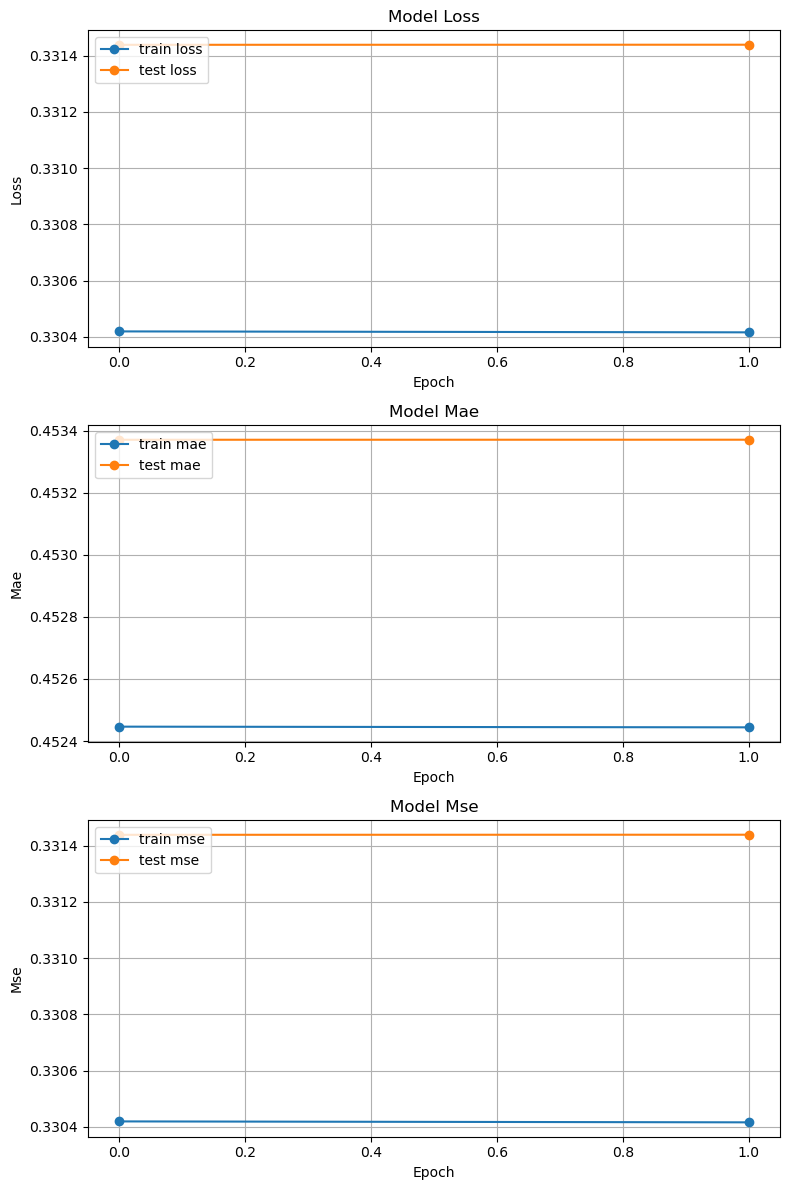

In [45]:
metrics = ["loss", "mae", "mse"]

fig, axes = plt.subplots(len(metrics), 1, figsize=(8, len(metrics) * 4))

for i, metric in enumerate(metrics):
    ax = axes[i]
    ax.plot(history[metric][0:-2], marker="o", label=f"train {metric}")
    ax.plot(history[f"val_{metric}"][0:-2], marker="o", label=f"test {metric}")
    ax.set_title(f"Model {metric.capitalize()}")
    ax.set_ylabel(metric.capitalize())
    ax.set_xlabel("Epoch")
    ax.legend(loc="upper left")
    ax.grid(True)

plt.tight_layout()
plt.show()

In [47]:
class InferenceCache:
    def __init__(self, model, device):
        self.model = model
        self.device = device
        self.user_embeddings_cache = {}
        self.anime_embeddings_cache = None
        self.top_k_cache = {}

    def precompute_anime_embeddings(self, n_anime):
        print("Precomputing all anime embeddings...")
        self.model.eval()
        with torch.no_grad():
            anime_ids = torch.arange(n_anime).to(self.device)
            self.anime_embeddings_cache = self.model.anime_embedding(anime_ids)
            norms = torch.norm(self.anime_embeddings_cache, p=2, dim=1, keepdim=True)
            self.anime_embeddings_cache = self.anime_embeddings_cache / (norms + 1e-8)
        print(f"[CACHED] {n_anime} anime embeddings")

    def get_user_embedding(self, user_id):
        if user_id not in self.user_embeddings_cache:
            self.model.eval()
            with torch.no_grad():
                user_t = torch.LongTensor([user_id]).to(self.device)
                emb = self.model.user_embedding(user_t)
                norm = torch.norm(emb, p=2, dim=1, keepdim=True)
                self.user_embeddings_cache[user_id] = emb / (norm + 1e-8)
        return self.user_embeddings_cache[user_id]

    def recommend_for_user(self, user_id, k=10, exclude_watched=None):
        user_emb = self.get_user_embedding(user_id)
    
        scores = torch.sum(
            user_emb * self.anime_embeddings_cache,
            dim=1
        )
    
        if exclude_watched is not None:
            for anime_id in exclude_watched:
                scores[anime_id] = -float("inf")
    
        topk_scores, topk_indices = torch.topk(scores, k)
    
        return topk_indices.cpu().numpy(), topk_scores.cpu().numpy()


    def clear_cache(self):
        self.user_embeddings_cache = {}
        self.top_k_cache = {}
        print("[CLEARED] Cache cleared")

inference_cache = InferenceCache(model, device)
inference_cache.precompute_anime_embeddings(n_anime)

Precomputing all anime embeddings...
[CACHED] 17560 anime embeddings


In [47]:
def extract_weights(name, model):
    weights = model.anime_embedding.weight.data.cpu().numpy() if name == "anime_embedding" else model.user_embedding.weight.data.cpu().numpy()
    return weights / np.linalg.norm(weights, axis=1).reshape((-1, 1))
anime_similarity_cache = {}
user_similarity_cache = {}

In [48]:
anime_weights = extract_weights("anime_embedding", model)

In [49]:
user_weights = extract_weights("user_embedding", model)

In [50]:
df = pd.read_csv(INPUT_DIR+"/anime.csv",low_memory=True)
df.head(2)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0


In [51]:
df = df.replace("Unknown",np.nan)

In [52]:
def getAnimeName(anime_id):
    try:
        name = df[df.anime_id == anime_id].eng_version.values[0]
        if name is np.nan:
            name = df[df.anime_id == anime_id].Name.values[0]
    except:
        print("Error")
    return name

In [53]:
df["anime_id"] = df["MAL_ID"]
df["eng_version"] = df["English name"]
df["eng_version"] = df.anime_id.apply(lambda x:getAnimeName(x))

In [54]:
getAnimeName(6702)

'Fairy Tail'

In [55]:
df.sort_values(by=["Score"],
               inplace=True,
               ascending=False,
               kind="quicksort",
               na_position="last")

In [56]:
df.columns

Index(['MAL_ID', 'Name', 'Score', 'Genres', 'English name', 'Japanese name',
       'Type', 'Episodes', 'Aired', 'Premiered', 'Producers', 'Licensors',
       'Studios', 'Source', 'Duration', 'Rating', 'Ranked', 'Popularity',
       'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
       'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6',
       'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1', 'anime_id',
       'eng_version'],
      dtype='object')

In [57]:
df = df[["anime_id" , "eng_version","Score","Genres","Episodes","Type","Premiered","Members"]]

In [58]:
df.head()

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",64,TV,Spring 2009,2248456
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",16,TV,Winter 2021,733260
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,Spring 2011,1771162
14963,38524,Attack on Titan Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Sho...",10,TV,Spring 2019,1073626
9913,28977,Gintama Season 4,9.1,"Action, Comedy, Historical, Parody, Samurai, S...",51,TV,Spring 2015,404121


In [59]:
def getAnimeFrame(anime,df):
    if isinstance(anime,int):
        return df[df.anime_id == anime]
    if isinstance(anime,str):
        return df[df.eng_version == anime]

In [60]:
getAnimeFrame(40028 , df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",16,TV,Winter 2021,733260


In [61]:
getAnimeFrame("Steins;Gate",df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,Spring 2011,1771162


In [62]:
cols = ["MAL_ID","Name","Genres","sypnopsis"]

In [63]:
synopsis_df = pd.read_csv(INPUT_DIR+"/anime_with_synopsis.csv",usecols=cols)

In [64]:
synopsis_df.head(1)

,MAL_ID,Name,Genres,sypnopsis
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized sever..."


In [65]:
synopsis_df.columns

Index(['MAL_ID', 'Name', 'Genres', 'sypnopsis'], dtype='object')

In [66]:
def getSynopsis(anime,synopsis_df):
    if isinstance(anime,int):
        return synopsis_df[synopsis_df.MAL_ID == anime].sypnopsis.values[0]
    if isinstance(anime,str):
        return synopsis_df[synopsis_df.Name == anime].sypnopsis.values[0]

In [67]:
getSynopsis(40028 , synopsis_df)

"Gabi Braun and Falco Grice have been training their entire lives to inherit one of the seven titans under Marley's control and aid their nation in eradicating the Eldians on Paradis. However, just as all seems well for the two cadets, their peace is suddenly shaken by the arrival of Eren Yeager and the remaining members of the Survey Corps. Having finally reached the Yeager family basement and learned about the dark history surrounding the titans, the Survey Corps has at long last found the answer they so desperately fought to uncover. With the truth now in their hands, the group set out for the world beyond the walls. In Shingeki no Kyojin: The Final Season , two utterly different worlds collide as each party pursues its own agenda in the long-awaited conclusion to Paradis' fight for freedom."

In [68]:
getSynopsis("Steins;Gate",synopsis_df)

'The self-proclaimed mad scientist Rintarou Okabe rents out a room in a rickety old building in Akihabara, where he indulges himself in his hobby of inventing prospective "future gadgets" with fellow lab members: Mayuri Shiina, his air-headed childhood friend, and Hashida Itaru, a perverted hacker nicknamed "Daru." The three pass the time by tinkering with their most promising contraption yet, a machine dubbed the "Phone Microwave," which performs the strange function of morphing bananas into piles of green gel. Though miraculous in itself, the phenomenon doesn\'t provide anything concrete in Okabe\'s search for a scientific breakthrough; that is, until the lab members are spurred into action by a string of mysterious happenings before stumbling upon an unexpected success—the Phone Microwave can send emails to the past, altering the flow of history. Adapted from the critically acclaimed visual novel by 5pb. and Nitroplus, Steins;Gate takes Okabe through the depths of scientific theory 

In [69]:
pd.set_option("max_colwidth",None)

In [70]:
def find_similar_animes(name, anime_weights, anime2anime_encoded, anime2anime_decoded, df, synopsis_df, n=10, return_dist=False, neg=False):
    anime_frame = getAnimeFrame(name, df)
    if anime_frame.empty:
        print(f"Anime '{name}' not found in database")
        return pd.DataFrame()
    index = anime_frame.anime_id.values[0]
    encoded_index = anime2anime_encoded.get(index)
    if encoded_index is None:
        return pd.DataFrame()
    dists = np.dot(anime_weights, anime_weights[encoded_index])
    sorted_dists = np.argsort(dists)
    n = n + 1
    closest = sorted_dists[:n] if neg else sorted_dists[-n:]
    if return_dist:
        return dists, closest
    SimilarityArr = []
    for close in closest:
        decoded_id = anime2anime_decoded.get(close)
        anime_frame_sim = getAnimeFrame(decoded_id, df)
        if not anime_frame_sim.empty:
            anime_name = anime_frame_sim.eng_version.values[0]
            genre = anime_frame_sim.Genres.values[0]
            similarity = dists[close]
            SimilarityArr.append({"anime_id": decoded_id, "name": anime_name, "similarity": similarity, "genre": genre})
    Frame = pd.DataFrame(SimilarityArr).sort_values(by="similarity", ascending=False)
    return Frame[Frame.anime_id != index].drop(['anime_id'], axis=1)

In [71]:
find_similar_animes(
    "Steins;Gate",
    anime_weights,
    anime2anime_encoded,
    anime2anime_decoded,
    df,
    synopsis_df,
)

,name,similarity,genre
9,Kaidan,0.502286,Supernatural
8,Kinpatsu no Jeanie,0.492863,"Historical, Drama"
7,Fate/stay night:Heaven's Feel - I. Presage Flower,0.458057,"Action, Fantasy, Magic, Supernatural"
6,Madonna’s Temptation,0.451816,Dementia
5,"One Piece:Emergency Planning, A Perfect Strategy for the One Piece",0.418820,"Adventure, Comedy, Fantasy, Shounen"
4,Kamiusagi Rope x Ricordi,0.411765,"Comedy, Slice of Life"
3,Ginga Hyouryuu Vifam: Kieta 12-nin,0.411031,"Sci-Fi, Adventure, Space, Comedy, Mecha"
2,Hungry to Win,0.410272,"Action, Sports"
1,"McDull, Kung Fu Kindergarten",0.410223,Comedy
0,Slam Dunk (Movie),0.401517,"Comedy, Drama, School, Shounen, Slice of Life, Sports"


In [72]:
def find_similar_users(item_input, user_weights, user2user_encoded, user2user_decoded, n=10, return_dist=False, neg=False):
    try:
        encoded_index = user2user_encoded.get(item_input)
        if encoded_index is None:
            print(f"User ID {item_input} not found in database")
            return pd.DataFrame()
        dists = np.dot(user_weights, user_weights[encoded_index])
        sorted_dists = np.argsort(dists)
        n = n + 1
        closest = sorted_dists[:n] if neg else sorted_dists[-n:]
        if return_dist:
            return dists, closest
        SimilarityArr = [{"similar_users": user2user_decoded.get(close), "similarity": dists[close]} for close in closest if isinstance(item_input, int)]
        similar_users = pd.DataFrame(SimilarityArr).sort_values(by="similarity", ascending=False)
        return similar_users[similar_users.similar_users != item_input]
    except Exception as e:
        print("Error Occurred", e)
        return pd.DataFrame()

def get_popular_animes(df, rating_df, n=10):
    anime_counts = rating_df.groupby('anime_id').size().reset_index(name='count')
    anime_counts = anime_counts.merge(df[['anime_id', 'eng_version', 'Score', 'Genres']], on='anime_id').sort_values('count', ascending=False)
    return anime_counts[['eng_version', 'Score', 'Genres', 'count']].head(n)

def get_genre_based_recommendations(user_pref_genres, df, n=10):
    genre_scores = {}
    for idx, row in df.iterrows():
        if pd.notna(row['Genres']):
            genres = [g.strip() for g in str(row['Genres']).split(',')]
            for genre in user_pref_genres:
                if genre in genres:
                    genre_scores[row['eng_version']] = genre_scores.get(row['eng_version'], 0) + 1
    sorted_animes = sorted(genre_scores.items(), key=lambda x: x[1], reverse=True)
    return [anime for anime, score in sorted_animes[:n]]

In [73]:
find_similar_users(int(11880),user_weights,user2user_encoded,user2user_decoded)

,similar_users,similarity
9,13638,0.488658
8,14749,0.449177
7,11156,0.443423
6,1495,0.411663
5,20873,0.401136
4,7413,0.398229
3,9158,0.381534
2,23719,0.379691
1,17155,0.366122
0,17482,0.363822


In [74]:
def showWordCloud(all_genres):
    genres_cloud = WordCloud(width=700,height=400,background_color='white',colormap='gnuplot').generate_from_frequencies(all_genres)
    plt.figure(figsize=(10,8))
    plt.imshow(genres_cloud,interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [75]:
df.head(1)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen",64,TV,Spring 2009,2248456


In [76]:
def getFavGenre(frame , plot=False):
    frame.dropna(inplace=False)
    all_genres = defaultdict(int)

    genres_list = []
    for genres in frame["Genres"]:
        if isinstance(genres,str):
            for genre in genres.split(','):
                genres_list.append(genre)
                all_genres[genre.strip()] += 1

    if plot:
        showWordCloud(all_genres)

    return genres_list

In [77]:
rating_df.head(2)

,user_id,anime_id,rating,user,anime
0,16869,2746,0.0,4294,2446
1,19497,14345,0.7,4982,1149


In [78]:
def get_user_preferences(user_id , rating_df , df ,plot=False):

    animes_watched_by_user = rating_df[rating_df.user_id == user_id]

    if animes_watched_by_user.empty:
        print(f"User {user_id} has no ratings in the database.")
        return pd.DataFrame(columns=["eng_version","Genres"])

    user_rating_percentile = np.percentile(animes_watched_by_user.rating , 75)

    animes_watched_by_user = animes_watched_by_user[animes_watched_by_user.rating >= user_rating_percentile]

    top_animes_user = (
        animes_watched_by_user.sort_values(by="rating" , ascending=False).anime_id.values
    )

    anime_df_rows = df[df["anime_id"].isin(top_animes_user)]
    anime_df_rows = anime_df_rows[["eng_version","Genres"]]

    if plot:
        getFavGenre(anime_df_rows,plot)

    return anime_df_rows

In [83]:
from wordcloud import WordCloud


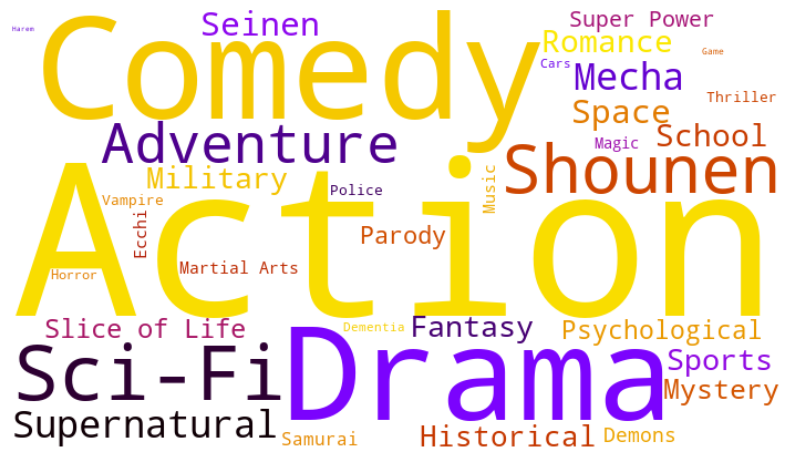

,eng_version,Genres
3971,Fullmetal Alchemist:Brotherhood,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen"
9913,Gintama Season 4,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen"
6474,Hunter x Hunter,"Action, Adventure, Fantasy, Shounen, Super Power"
6006,Gintama Season 2,"Action, Sci-Fi, Comedy, Historical, Parody, Samurai, Shounen"
741,Legend of the Galactic Heroes,"Military, Sci-Fi, Space, Drama"
...,...,...
2575,Shootfighter Tekken,"Action, Martial Arts, Shounen"
8064,Samurai Flamenco,"Action, Comedy, Parody, Super Power"
510,Venus Wars,"Action, Sci-Fi, Adventure, Space"
6864,Saint Seiya Omega,"Action, Adventure, Fantasy, Shounen"


In [84]:
get_user_preferences(11880 , rating_df, df , plot=True)

In [85]:
def get_user_recommendations(similar_users, user_pref, df, synopsis_df, rating_df, n=10):
    if similar_users.empty:
        print("No similar users found. Using genre-based recommendations.")
        user_pref_genres = [g.strip() for genres in user_pref["Genres"] if isinstance(genres, str) for g in genres.split(',')]
        genre_recs = get_genre_based_recommendations(user_pref_genres, df, n)
        return pd.DataFrame({'anime_name': genre_recs})
    anime_list = []
    for user_id in similar_users.similar_users.values:
        pref_list = get_user_preferences(int(user_id), rating_df, df)
        pref_list = pref_list[~pref_list.eng_version.isin(user_pref.eng_version.values)]
        if not pref_list.empty:
            anime_list.extend(pref_list.eng_version.values)
    if not anime_list:
        return pd.DataFrame()
    sorted_list = pd.DataFrame(pd.Series(anime_list).value_counts()).head(n)
    recommended_animes = []
    for anime_name in sorted_list.index:
        if isinstance(anime_name, str):
            frame = getAnimeFrame(anime_name, df)
            if not frame.empty:
                anime_id = frame.anime_id.values[0]
                recommended_animes.append({"n": sorted_list.loc[anime_name].values[0], "anime_name": anime_name, "Genres": frame.Genres.values[0], "Synopsis": getSynopsis(int(anime_id), synopsis_df)})
    return pd.DataFrame(recommended_animes).head(n) if recommended_animes else pd.DataFrame()

In [86]:
similar_users =find_similar_users(int(11880),user_weights,user2user_encoded,user2user_decoded)

In [87]:
user_pref = get_user_preferences(11880 , rating_df, df , plot=False)

In [88]:
get_user_recommendations(similar_users,user_pref,df, synopsis_df,rating_df,n=1)

,n,anime_name,Genres,Synopsis
0,7,Monthly Girls' Nozaki-kun,"Comedy, Romance, School","Chiyo Sakura is a cheerful high school girl who has fallen head over heels for the oblivious Umetarou Nozaki. Much to Chiyo's confusion, when she confesses to her beloved Nozaki, he hands her an unfamiliar autograph. As it turns out, the stoic teenage boy is actually a respected shoujo mangaka, publishing under the pen name Sakiko Yumeno! A series of misunderstandings leads to Chiyo becoming one of Nozaki's manga assistants. Throughout the hilarious events that ensue, she befriends many of her quirky schoolmates, including her seemingly shameless fellow assistant, Mikoto Mikoshiba, and the ""Prince of the School,"" Yuu Kashima. Gekkan Shoujo Nozaki-kun follows Chiyo as she strives to help Nozaki with his manga and hopes that he will eventually notice her feelings."


In [89]:
def hybrid_recommendation(user_id, user_weight=0.5, content_weight=0.5):
    if user_id not in user2user_encoded:
        print(f"User {user_id} is new. Using popularity-based recommendations.")
        return get_popular_animes(df, rating_df, n=10)['eng_version'].tolist()
    try:
        similar_users = find_similar_users(user_id, user_weights, user2user_encoded, user2user_decoded)
        user_pref = get_user_preferences(user_id, rating_df, df)
        user_recommended_animes = get_user_recommendations(similar_users, user_pref, df, synopsis_df, rating_df)
        if user_recommended_animes.empty:
            print(f"No recommendations found for user {user_id}. Using popular animes.")
            return get_popular_animes(df, rating_df, n=10)['eng_version'].tolist()
        user_recommended_anime_list = user_recommended_animes["anime_name"].tolist()
        print(f"User-based recommendations: {user_recommended_anime_list}")
        content_recommended_animes = []
        for anime in user_recommended_anime_list:
            similar_animes = find_similar_animes(anime, anime_weights, anime2anime_encoded, anime2anime_decoded, df, synopsis_df)
            if similar_animes is not None and not similar_animes.empty:
                content_recommended_animes.extend(similar_animes["name"].tolist())
            else:
                print(f"No similar anime found for {anime}")
        combined_scores = {anime: user_weight for anime in user_recommended_anime_list}
        for anime in content_recommended_animes:
            combined_scores[anime] = combined_scores.get(anime, 0) + content_weight
        sorted_animes = sorted(combined_scores.items(), key=lambda x: x[1], reverse=True)
        return [anime for anime, score in sorted_animes[:10]]
    except Exception as e:
        print(f"Error in hybrid recommendation: {e}. Using popular animes.")
        return get_popular_animes(df, rating_df, n=10)['eng_version'].tolist()

In [90]:
hybrid_recommendation(11880)

User-based recommendations: ["Monthly Girls' Nozaki-kun", 'Death Note', 'Shelter', 'Made in Abyss', 'Princess Mononoke', 'Code Geass:Lelouch of the Rebellion', 'Steins;Gate', "Howl's Moving Castle", 'The Girl Who Leapt Through Time', 'Ouran High School Host Club']


["Monthly Girls' Nozaki-kun",
 'Death Note',
 'Shelter',
 'Made in Abyss',
 'Princess Mononoke',
 'Code Geass:Lelouch of the Rebellion',
 'Steins;Gate',
 "Howl's Moving Castle",
 'The Girl Who Leapt Through Time',
 'Ouran High School Host Club']

In [91]:
def calculate_ranking_metrics(y_true, y_pred, k=10):
    y_true_binary = (y_true >= 0.5).astype(int)
    sorted_idx = np.argsort(y_pred)[::-1][:k]
    top_k_actual = y_true_binary[sorted_idx]
    precision_k = np.mean(top_k_actual)
    num_relevant = np.sum(y_true_binary)
    recall_k = np.sum(top_k_actual) / num_relevant if num_relevant > 0 else 0
    ideal_scores = np.sort(y_true_binary)[::-1][:k]
    ndcg_k = np.sum(top_k_actual / np.log2(np.arange(2, k + 2))) / np.sum(ideal_scores / np.log2(np.arange(2, k + 2))) if np.sum(ideal_scores) > 0 else 0
    return {'precision@10': precision_k, 'recall@10': recall_k, 'ndcg@10': ndcg_k}

def leave_one_out_evaluation_vectorized(model, rating_df, anime2anime_encoded, user2user_encoded, device, max_users=1000, k=10, batch_size=512):
    all_users = rating_df['user_id'].unique()[:max_users]
    lao_metrics = {'precision': [], 'recall': [], 'ndcg': []}
    model.eval()
    all_anime_encoded = list(anime2anime_encoded.keys())
    for user_id in all_users:
        user_ratings = rating_df[rating_df['user_id'] == user_id].copy()
        if len(user_ratings) < 2:
            continue
        held_out_idx = np.random.choice(user_ratings.index, 1)[0]
        held_out_anime = rating_df.loc[held_out_idx, 'anime_id']
        train_ratings = user_ratings.drop(held_out_idx)
        user_encoded = user2user_encoded.get(user_id)
        if user_encoded is None:
            continue
        watched_animes = set(train_ratings['anime_id'].values)
        negatives = [a for a in all_anime_encoded if a not in watched_animes][:99]
        test_animes = [held_out_anime] + negatives
        test_encoded = [anime2anime_encoded[a] for a in test_animes if a in anime2anime_encoded]
        if len(test_encoded) == 0:
            continue
        scores = []
        with torch.no_grad():
            for i in range(0, len(test_encoded), batch_size):
                batch_animes = test_encoded[i:i+batch_size]
                users_t = torch.LongTensor([user_encoded] * len(batch_animes)).to(device)
                animes_t = torch.LongTensor(batch_animes).to(device)
                batch_scores = model(users_t, animes_t).cpu().numpy()
                scores.extend(batch_scores)
        scores = np.array(scores)
        ranked = np.argsort(scores)[::-1]
        held_out_rank = np.where(ranked == 0)[0][0] if 0 in ranked else len(ranked)
        precision = 1.0 if held_out_rank < k else 0.0
        recall = 1.0 if held_out_rank < k else 0.0
        dcg = 1.0 / np.log2(held_out_rank + 2) if held_out_rank < len(scores) else 0.0
        idcg = 1.0
        ndcg = dcg / idcg
        lao_metrics['precision'].append(precision)
        lao_metrics['recall'].append(recall)
        lao_metrics['ndcg'].append(ndcg)
    return {k: np.mean(v) if v else 0.0 for k, v in lao_metrics.items()}

print("\n" + "="*60)
print("FINAL EVALUATION")
print("="*60)

model.eval()
test_predictions, test_actuals = [], []
with torch.no_grad():
    for users, animes, ratings in test_loader:
        users, animes = users.to(device), animes.to(device)
        outputs = model(users, animes)
        test_predictions.extend(outputs.cpu().numpy())
        test_actuals.extend(ratings.cpu().numpy())
test_predictions, test_actuals = np.array(test_predictions), np.array(test_actuals)
mae = np.mean(np.abs(test_predictions - test_actuals))
rmse = np.sqrt(np.mean((test_predictions - test_actuals) ** 2))
ranking_metrics = calculate_ranking_metrics(test_actuals, test_predictions, k=10)

print("\nRunning Leave-One-Out evaluation...")
lao_results = leave_one_out_evaluation_vectorized(model, rating_df, anime2anime_encoded, user2user_encoded, device, max_users=1000, k=10, batch_size=512)

print("\n" + "="*60)
print("METRICS SUMMARY")
print("="*60)
print(f"Training Mode: {CONFIG['TRAINING_MODE']}")
print(f"Embedding Size: {CONFIG['embedding_size']}")
print("-"*60)
print("Test Set Metrics:")
print(f"  MAE: {mae:.4f}")
print(f"  RMSE: {rmse:.4f}")
print(f"  Precision@10: {ranking_metrics['precision@10']:.4f}")
print(f"  Recall@10: {ranking_metrics['recall@10']:.4f}")
print(f"  NDCG@10: {ranking_metrics['ndcg@10']:.4f}")
print("-"*60)
print("Leave-One-Out Metrics:")
print(f"  Precision@10: {lao_results['precision']:.4f}")
print(f"  Recall@10: {lao_results['recall']:.4f}")
print(f"  NDCG@10: {lao_results['ndcg']:.4f}")
print("="*60)

final_metrics = {
    'test_mae': mae,
    'test_rmse': rmse,
    'test_precision': ranking_metrics['precision@10'],
    'test_recall': ranking_metrics['recall@10'],
    'test_ndcg': ranking_metrics['ndcg@10'],
    'loo_precision': lao_results['precision'],
    'loo_recall': lao_results['recall'],
    'loo_ndcg': lao_results['ndcg']
}
save_model_checkpoint(model, optimizer, CONFIG['epochs'], final_metrics, CONFIG, 'final_model_with_metrics.pth')


FINAL EVALUATION

Running Leave-One-Out evaluation...

METRICS SUMMARY
Training Mode: MSE
Embedding Size: 64
------------------------------------------------------------
Test Set Metrics:
  MAE: 0.4533
  RMSE: 0.5757
  Precision@10: 0.6000
  Recall@10: 0.0000
  NDCG@10: 0.5927
------------------------------------------------------------
Leave-One-Out Metrics:
  Precision@10: 0.0920
  Recall@10: 0.0920
  NDCG@10: 0.2074
[SAVED] /home/sagemaker-user/models/final_model_with_metrics.pth


'/home/sagemaker-user/models/final_model_with_metrics.pth'

In [48]:
print("\n" + "="*60)
print("FAST INFERENCE WITH CACHE")
print("="*60)
test_user_id = 0
watched_anime = rating_df[rating_df['user'] == test_user_id]['anime'].values[:10]
print(f"\nUser {test_user_id} - Getting top 10 recommendations (excluding watched)...\n")

start = time.time()
recommended_indices, recommended_scores = inference_cache.recommend_for_user(test_user_id, k=10, exclude_watched=watched_anime)
elapsed = time.time() - start
print(f"[INFERENCE TIME] {elapsed*1000:.2f}ms")
print(f"\nTop 10 Recommended Anime IDs: {recommended_indices}")

print(f"Scores: {recommended_scores}")
print("="*60)


FAST INFERENCE WITH CACHE

User 0 - Getting top 10 recommendations (excluding watched)...

[INFERENCE TIME] 0.93ms

Top 10 Recommended Anime IDs: [ 3333  8436 16423  1762 13883 13545  8983 12829 15090 11306]
Scores: [0.50695044 0.47500393 0.47045588 0.47007513 0.43349898 0.4133429
 0.41146737 0.40459892 0.39893878 0.39794385]


In [44]:
print("\n" + "="*60)
print("SAVED MODELS SUMMARY")
print("="*60)
import glob
model_files = glob.glob(os.path.join(CONFIG['save_dir'], '*.pth'))
if model_files:
    print()
    for model_file in sorted(model_files):
        file_size = os.path.getsize(model_file) / 1024 / 1024
        print(f"  [MODEL] {os.path.basename(model_file)} ({file_size:.2f} MB)")
else:
    print("No models saved yet.")
print()
print("To load a model:")
print("  checkpoint = torch.load('path/to/model.pth')")
print("  model.load_state_dict(checkpoint['model_state_dict'])")
print("  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])")
print("="*60)


SAVED MODELS SUMMARY
No models saved yet.

To load a model:
  checkpoint = torch.load('path/to/model.pth')
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])


In [45]:
def load_model_for_inference(checkpoint_path, n_users, n_anime, embedding_size, device):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model = RecommenderNet(n_users, n_anime, embedding_size=embedding_size).to(device)
    if 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"[LOADED] Checkpoint from epoch {checkpoint.get('epoch', 'unknown')}")
        print(f"[METRICS] {checkpoint.get('metrics', {})}")
    else:
        model.load_state_dict(checkpoint)
        print(f"[LOADED] Weights only")
    model.eval()
    return model

def get_recommendations_batch(model, user_ids, n_anime, device, k=10, batch_size=1024):
    model.eval()
    all_recommendations = {}
    all_anime_ids = torch.arange(n_anime).to(device)
    with torch.no_grad():
        for user_id in user_ids:
            user_tensor = torch.LongTensor([user_id] * n_anime).to(device)
            scores = []
            for i in range(0, n_anime, batch_size):
                batch_anime = all_anime_ids[i:i+batch_size]
                batch_user = user_tensor[i:i+batch_size]
                batch_scores = model(batch_user, batch_anime)
                scores.extend(batch_scores.cpu().numpy())
            scores = np.array(scores)
            top_k_indices = np.argsort(scores)[::-1][:k]
            all_recommendations[user_id] = {
                'anime_ids': top_k_indices,
                'scores': scores[top_k_indices]
            }
    return all_recommendations

print("Use load_model_for_inference() to load saved models")
print("Use get_recommendations_batch() for batch predictions")
print("Use InferenceCache for real-time single-user predictions")

print(f"\n{'='*60}")
print("[SAVED] MODEL SAVING SUMMARY")

print(f"{'='*60}\n")
print(f"All models have been saved to: {CONFIG['save_dir']}")
print(f"\nSaved models include:")
print(f"  [1] final_model_{CONFIG['TRAINING_MODE']}.pth - Model weights only")
print(f"  [2] final_checkpoint_{CONFIG['TRAINING_MODE']}.pth - Full checkpoint with optimizer state")
print(f"  [3] final_model_with_metrics.pth - Model with evaluation metrics")
print(f"  [4] Periodic checkpoints - Saved every 5 epochs during training")
print(f"\nYou can load any model using:")
print(f"  model = load_model_for_inference(checkpoint_path, n_users, n_anime, embedding_size, device)")
print(f"{'='*60}\n")

Use load_model_for_inference() to load saved models
Use get_recommendations_batch() for batch predictions
Use InferenceCache for real-time single-user predictions

[SAVED] MODEL SAVING SUMMARY

All models have been saved to: /home/sagemaker-user/models

Saved models include:
  [1] final_model_MSE.pth - Model weights only
  [2] final_checkpoint_MSE.pth - Full checkpoint with optimizer state
  [3] final_model_with_metrics.pth - Model with evaluation metrics
  [4] Periodic checkpoints - Saved every 5 epochs during training

You can load any model using:
  model = load_model_for_inference(checkpoint_path, n_users, n_anime, embedding_size, device)

